In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

In [15]:
data = pd.read_csv('data.csv')
data['interaction'] = data['group'] * data['engagement']
data

,Unnamed: 0,T,purchase,deauth,group,engagement,sub_length,cancelled,interaction
0,0,0.221218,False,True,0,0.280561,NaN,NaN,0.000000
1,1,0.011139,True,False,0,1.318036,0.041083,False,0.000000
2,2,0.401563,False,False,0,0.048684,NaN,NaN,0.000000
3,3,0.000017,False,False,0,0.006747,NaN,NaN,0.000000
4,4,0.700210,False,True,0,0.751458,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...
9995,9995,0.621168,False,True,1,0.986779,NaN,NaN,0.986779
9996,9996,0.868310,False,True,1,0.254245,NaN,NaN,0.254245
9997,9997,0.004248,True,False,1,0.115631,0.542044,False,0.115631
9998,9998,0.035166,False,True,1,0.009601,NaN,NaN,0.009601


In [62]:
data.groupby(['purchase', 'deauth']).count() # No person with both deauth and purchase

Unnamed: 0     T  group  engagement  sub_length  cancelled  \
purchase deauth                                                               
False    False         3146  3146   3146        3146           0          0   
         True          3657  3657   3657        3657           0          0   
True     False         3197  3197   3197        3197        3197       3197   

                 interaction  
purchase deauth               
False    False          3146  
         True           3657  
True     False          3197

In [47]:
X = data[['group', 'engagement', 'interaction']]
T = data['T']

C_del = T.copy()
C_del[data['deauth']==True]=None #censoring vector for deauth

C_pur = T.copy()
C_pur[data['purchase']==True]=None #censoring vector for purchase

sub = data['sub_length'][~data['cancelled'].isna()]
can = data['cancelled'][~data['cancelled'].isna()]
C_sub = sub.copy()
C_sub[can] = None #censoring vector for sub_length

In [55]:
model = pm.Model()

with model:
    
    # deletion
    b_del = pm.Normal('b_del', tau=1, size=3)
    theta_del = pm.math.exp(pm.math.dot(X, b_del))
    alpha_del = pm.HalfNormal('alpha_del', tau=5)
    beta_del = pm.HalfNormal('beta_del', tau=5)
    dist_del = pm.Weibull.dist(alpha=alpha_del, beta=beta_del * theta_del)
    obs_del = pm.Censored('obs_del',
                      dist=dist_del,
                      lower=None,
                      upper=C_del,
                      observed=T)
    
    
    # purchase 
    b_pur = pm.Normal('b_pur', tau=1, size=3)
    theta_pur = pm.math.exp(pm.math.dot(X, b_pur))
    alpha_pur = pm.HalfNormal('alpha_pur', tau=5)
    beta_pur = pm.HalfNormal('beta_pur', tau=5)
    dist_pur = pm.Weibull.dist(alpha=alpha_pur, beta=beta_pur * theta_pur)
    obs_pur = pm.Censored('obs_pur',
                      dist=dist_pur,
                      lower=None,
                      upper=C_pur,
                      observed=T)
    
    # cancel
    b_can = pm.Normal('b_can', tau=1, size=3)
    theta_can = pm.math.exp(pm.math.dot(X[~data['cancelled'].isna()], b_can))
    alpha_can = pm.HalfNormal('alpha_can', tau=5)
    beta_can = pm.HalfNormal('beta_can', tau=5)
    dist_can = pm.Weibull.dist(alpha=alpha_can, beta=beta_can * theta_can)
    obs_can = pm.Censored('obs_can',
                      dist=dist_can,
                      lower=None,
                      upper=C_sub,
                      observed=sub)
    
    
    idata = pm.sample()
    pm.sample_posterior_predictive(idata,extend_inferencedata=True)

f = az.summary(idata)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_del, alpha_del, beta_del, b_pur, alpha_pur, beta_pur, b_can, alpha_can, beta_can]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1948 seconds.


In [56]:
f

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_del[0],0.018,0.037,-0.054,0.083,0.001,0.001,3471.0,2836.0,1.0
b_del[1],0.017,0.016,-0.012,0.049,0.000,0.000,3356.0,3098.0,1.0
b_del[2],0.019,0.023,-0.022,0.067,0.000,0.000,3165.0,3214.0,1.0
b_pur[0],-0.271,0.082,-0.424,-0.124,0.001,0.001,3496.0,3246.0,1.0
b_pur[1],0.018,0.037,-0.050,0.090,0.001,0.001,3151.0,2920.0,1.0
b_pur[2],-0.198,0.046,-0.285,-0.113,0.001,0.001,3130.0,3085.0,1.0
b_can[0],0.477,0.086,0.310,0.635,0.001,0.001,3649.0,3236.0,1.0
b_can[1],0.083,0.036,0.016,0.148,0.001,0.000,3573.0,2736.0,1.0
b_can[2],-0.033,0.049,-0.125,0.055,0.001,0.001,3549.0,2943.0,1.0
alpha_del,1.097,0.013,1.071,1.121,0.000,0.000,5039.0,3035.0,1.0


array([<AxesSubplot: xlabel='obs_del / obs_del'>,
       <AxesSubplot: xlabel='obs_pur / obs_pur'>,
       <AxesSubplot: xlabel='obs_can / obs_can'>], dtype=object)

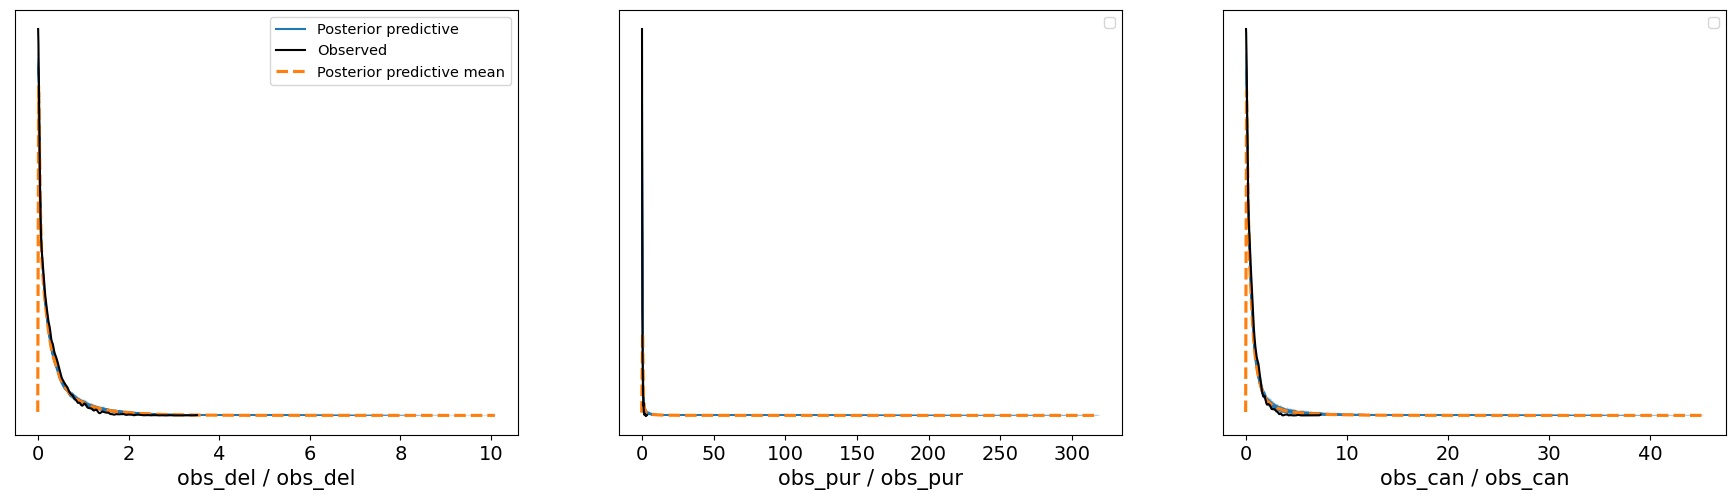

In [57]:
az.plot_ppc(idata, num_pp_samples=100) 
# looks like our model fits pretty well! 
# So this is a sample from the censored Weibull distribution, right...?